# Spelunky Feature Extraction Pipeline

This notebook extracts structural features from Spelunky levels in the `captured_levels` folder.

**Pipeline Steps:**
1. Inspect the dataset
2. Load configuration
3. Extract platform graphs and structural metrics
4. Analyze and visualize results

In [1]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import pandas as pd

from structural_features import Physics, build_segment_graph, structural_metrics

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Dataset Inspection

In [2]:
# Inspect dataset
levels_dir = Path("captured_levels")
txt_files = sorted(levels_dir.glob("*.txt"))

print(f"📁 Dataset: {levels_dir}")
print(f"📄 Total levels: {len(txt_files)}")
print(f"\nFirst 10 files:")
for f in txt_files[:10]:
    print(f"  - {f.name}")

📁 Dataset: captured_levels
📄 Total levels: 528

First 10 files:
  - level_20251023_071250.txt
  - level_20251023_071304.txt
  - level_20251023_071313.txt
  - level_20251023_071322.txt
  - level_20251023_071329.txt
  - level_20251023_071336.txt
  - level_20251023_071342.txt
  - level_20251023_071343.txt
  - level_20251023_071349.txt
  - level_20251023_071356.txt


In [3]:
# Inspect a sample level
if txt_files:
    sample_file = txt_files[0]
    sample_rows = sample_file.read_text().strip().split('\n')
    
    print(f"📄 Sample: {sample_file.name}")
    print(f"   Dimensions: {len(sample_rows[0])} x {len(sample_rows)} (W x H)")
    print(f"\n   Level preview:")
    for row in sample_rows[:15]:
        print(f"   {row}")
    
    # Tile types
    all_chars = set(''.join(sample_rows))
    print(f"\n   Tile types: {sorted(all_chars)}")

📄 Sample: level_20251023_071250.txt
   Dimensions: 32 x 32 (W x H)

   Level preview:
   11111111111111111111111111111111
   11111111111111111111111100000001
   10000000000000000000011100100001
   10000000000011100111010001111001
   10000000000011111100010000000001
   10000000000011111000010000010111
   10000000000001000000000000L10D11
   10000000000010000000011111L11111
   10000000000010110000000011L11111
   11111001111000100000100000L00111
   11111111111111100000111111111111
   11111111111100000000111111111111
   11000000000000000000111111111111
   10000000000001111100011111111111
   10111001110000000L00011111111111

   Tile types: ['0', '1', 'D', 'E', 'L']


## 2. Load Configuration

In [4]:
# Load Spelunky config
config_path = "configs/spelunky.json"

with open(config_path, 'r') as f:
    cfg = json.load(f)

print("⚙️ Configuration loaded:")
print(json.dumps(cfg, indent=2))

⚙️ Configuration loaded:
{
  "width": 40,
  "height": 32,
  "seed": 103,
  "tiles": {
    "empty": ".",
    "platform": "1",
    "ground": "1",
    "ladder": "L",
    "start": "D",
    "goal": "E"
  },
  "generation": {
    "platform_density": 0.35,
    "max_segments_per_row": 5,
    "segment_len_min": 2,
    "segment_len_max": 6,
    "ground_rows": 2,
    "left_right_border": true
  },
  "physics": {
    "solids": [
      "1",
      "1"
    ],
    "jumps": [
      [
        [
          0,
          -1
        ],
        [
          0,
          -2
        ],
        [
          1,
          -2
        ],
        [
          1,
          -1
        ]
      ],
      [
        [
          0,
          -1
        ],
        [
          0,
          -2
        ],
        [
          -1,
          -2
        ],
        [
          -1,
          -1
        ]
      ],
      [
        [
          0,
          -1
        ],
        [
          0,
          -2
        ],
        [
          1,
 

In [5]:
# Create Physics object
physics = Physics(
    solids=set(cfg["physics"]["solids"]),
    jumps=[[(int(dx), int(dy)) for dx, dy in arc] 
           for arc in cfg["physics"]["jumps"]]
)

print(f"🎮 Physics configuration:")
print(f"   Solid tiles: {physics.solids}")
print(f"   Jump arcs: {len(physics.jumps)} defined")
for i, arc in enumerate(physics.jumps, 1):
    print(f"   Arc {i}: {arc}")

🎮 Physics configuration:
   Solid tiles: {'1'}
   Jump arcs: 4 defined
   Arc 1: [(0, -1), (0, -2), (1, -2), (1, -1)]
   Arc 2: [(0, -1), (0, -2), (-1, -2), (-1, -1)]
   Arc 3: [(0, -1), (0, -2), (1, -3), (2, -3), (2, -2)]
   Arc 4: [(0, -1), (0, -2), (-1, -3), (-2, -3), (-2, -2)]


## 3. Extract Structural Metrics

In [6]:
def extract_metrics_for_level(level_rows: List[str], physics: Physics, level_name: str) -> Dict:
    """Extract structural metrics from a single level."""
    try:
        # Build reachability graph
        G, id2seg = build_segment_graph(
            level_rows, 
            physics,
            mirror_arcs=True,
            enable_falls=True,
            subsample=1,
            ignore_frame_for_segments=True,
            max_fall=6
        )
        
        # Compute metrics
        metrics = structural_metrics(G, id2seg, max_len_for_style=None)
        
        # Add metadata
        metrics['level_name'] = level_name
        metrics['width'] = len(level_rows[0])
        metrics['height'] = len(level_rows)
        metrics['num_platforms'] = G.number_of_nodes()
        metrics['num_connections'] = G.number_of_edges()
        metrics['success'] = True
        
        return metrics
        
    except Exception as e:
        return {
            'level_name': level_name,
            'success': False,
            'error': str(e)
        }

In [7]:
# Extract metrics for all levels
results = {}
successful = 0
failed = []

print(f"🔍 Processing {len(txt_files)} levels...\n")

for i, txt_file in enumerate(txt_files, 1):
    level_name = txt_file.stem
    
    # Read level
    rows = txt_file.read_text().strip().split('\n')
    
    # Extract metrics
    metrics = extract_metrics_for_level(rows, physics, level_name)
    results[level_name] = metrics
    
    if metrics.get('success'):
        successful += 1
        status = f"✅ {metrics['num_platforms']} platforms, {metrics['num_connections']} edges"
    else:
        failed.append(level_name)
        status = f"❌ {metrics.get('error', 'Unknown error')}"
    
    print(f"[{i:3d}/{len(txt_files)}] {level_name:30s} {status}")

print(f"\n✅ Successfully processed: {successful}/{len(txt_files)}")
if failed:
    print(f"❌ Failed: {len(failed)} levels")
    print(f"   {failed[:5]}..." if len(failed) > 5 else f"   {failed}")

🔍 Processing 528 levels...

[  1/528] level_20251023_071250          ✅ 60 platforms, 72 edges
[  2/528] level_20251023_071304          ✅ 70 platforms, 85 edges
[  3/528] level_20251023_071313          ✅ 62 platforms, 57 edges
[  4/528] level_20251023_071322          ✅ 78 platforms, 86 edges
[  5/528] level_20251023_071329          ✅ 57 platforms, 56 edges
[  6/528] level_20251023_071336          ✅ 61 platforms, 71 edges
[  7/528] level_20251023_071342          ✅ 63 platforms, 71 edges
[  8/528] level_20251023_071343          ✅ 63 platforms, 71 edges
[  9/528] level_20251023_071349          ✅ 64 platforms, 79 edges
[ 10/528] level_20251023_071356          ✅ 66 platforms, 71 edges
[ 11/528] level_20251023_071403          ✅ 73 platforms, 78 edges
[ 12/528] level_20251023_071410          ✅ 66 platforms, 74 edges
[ 13/528] level_20251023_072439          ✅ 58 platforms, 70 edges
[ 14/528] level_20251023_072445          ✅ 53 platforms, 52 edges
[ 15/528] level_20251023_072450          ✅ 73 pl

In [9]:
# Save results
output_file = "spelunky_metrics.json"
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Results saved to {output_file}")

💾 Results saved to spelunky_metrics.json


## 4. Analysis & Visualization

In [10]:
# Create DataFrame from successful extractions
successful_data = {k: v for k, v in results.items() if v.get('success')}
df = pd.DataFrame.from_dict(successful_data, orient='index')

print(f"📊 Dataset shape: {df.shape}")
df.head(10)

📊 Dataset shape: (528, 12)


,room_count,branching,linearity,dead_end_rate,loop_complexity,segment_size_variance,level_name,width,height,num_platforms,num_connections,success
level_20251023_071250,2.0,2.400000,0.266667,0.133333,14.0,3.576389,level_20251023_071250,32,32,60,72,True
level_20251023_071304,2.0,2.428571,0.257143,0.171429,17.0,3.472653,level_20251023_071304,32,32,70,85,True
level_20251023_071313,7.0,1.838710,0.419355,0.338710,2.0,2.339490,level_20251023_071313,32,32,62,57,True
level_20251023_071322,5.0,2.205128,0.294872,0.217949,13.0,3.342538,level_20251023_071322,32,32,78,86,True
level_20251023_071329,6.0,1.964912,0.210526,0.245614,5.0,4.578640,level_20251023_071329,32,32,57,56,True
level_20251023_071336,5.0,2.327869,0.327869,0.163934,15.0,4.462779,level_20251023_071336,32,32,61,71,True
level_20251023_071342,4.0,2.253968,0.269841,0.222222,12.0,4.723104,level_20251023_071342,32,32,63,71,True
level_20251023_071343,4.0,2.253968,0.269841,0.222222,12.0,4.723104,level_20251023_071343,32,32,63,71,True
level_20251023_071349,2.0,2.468750,0.359375,0.187500,17.0,2.413086,level_20251023_071349,32,32,64,79,True
level_20251023_071356,4.0,2.151515,0.318182,0.242424,9.0,3.306933,level_20251023_071356,32,32,66,71,True


In [11]:
# Summary statistics
metric_cols = ['room_count', 'branching', 'linearity', 'dead_end_rate', 
               'loop_complexity', 'segment_size_variance']

print("📈 STRUCTURAL METRICS SUMMARY")
print("=" * 80)
df[metric_cols].describe().T

📈 STRUCTURAL METRICS SUMMARY


,count,mean,std,min,25%,50%,75%,max
room_count,528.0,4.172348,1.608396,1.000000,3.000000,4.000000,5.000000,9.000000
branching,528.0,2.174466,0.146475,1.795918,2.072727,2.169253,2.267164,2.666667
linearity,528.0,0.287857,0.063831,0.157143,0.239101,0.280702,0.327351,0.535714
dead_end_rate,528.0,0.227654,0.059395,0.071429,0.184615,0.222222,0.263158,0.460000
loop_complexity,528.0,9.589015,3.891268,0.000000,7.000000,9.000000,12.000000,24.000000
segment_size_variance,528.0,3.950600,1.195470,1.568163,3.114120,3.779096,4.655487,9.754367


💾 Saved: spelunky_metric_distributions.png


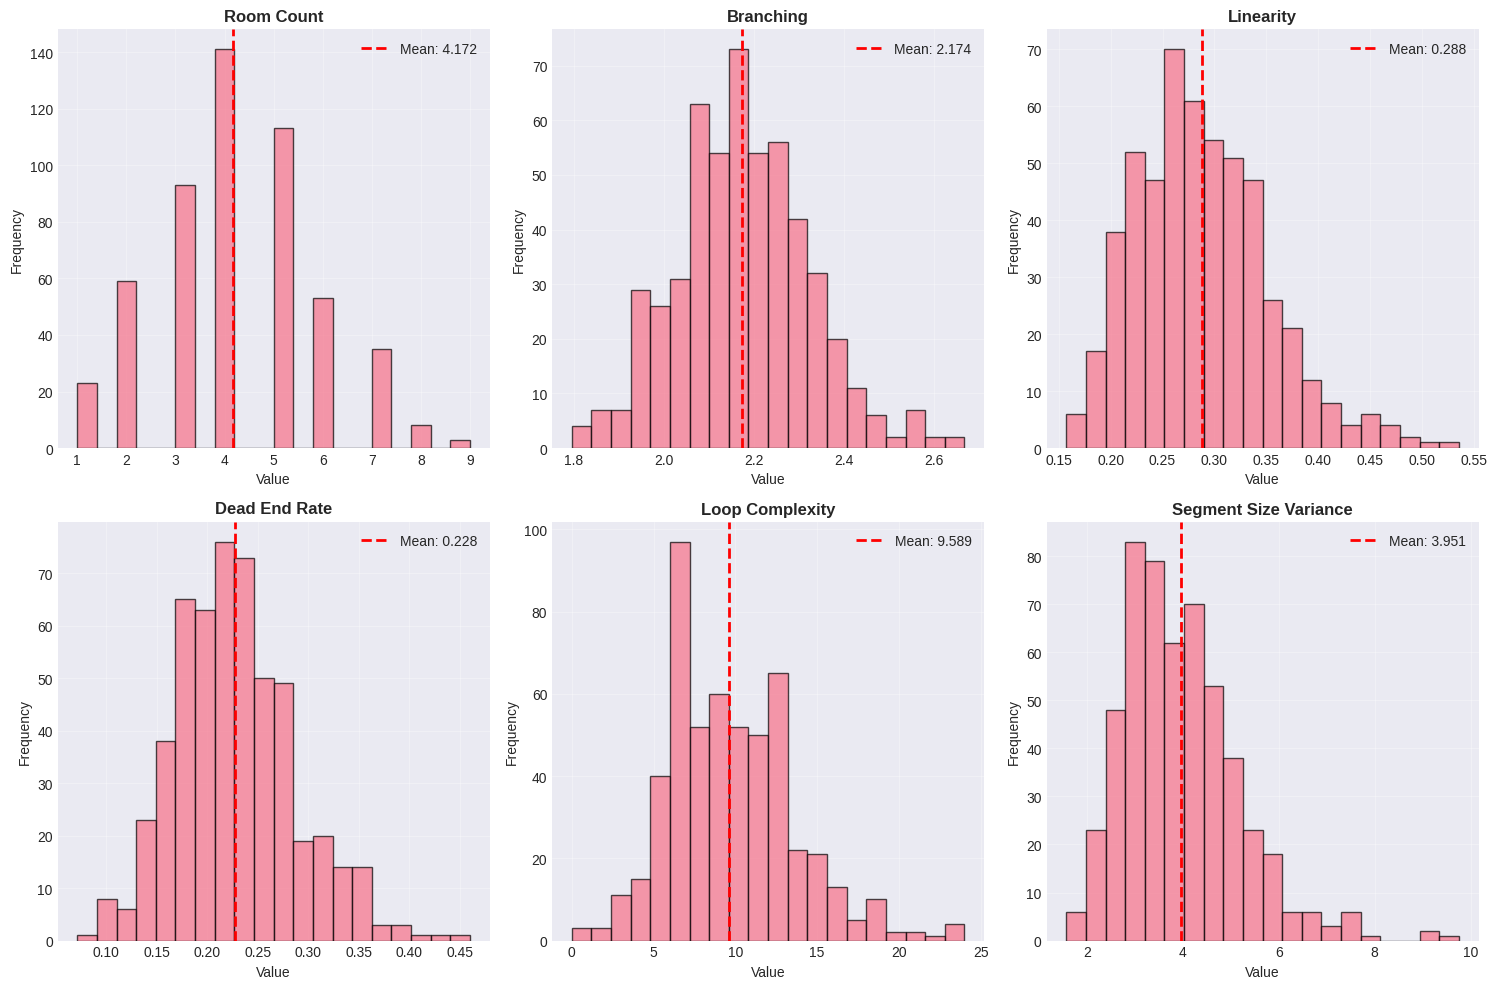

In [12]:
# Visualize metric distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    axes[i].hist(df[metric], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)
    
    # Add mean line
    mean_val = df[metric].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {mean_val:.3f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('spelunky_metric_distributions.png', dpi=150, bbox_inches='tight')
print("💾 Saved: spelunky_metric_distributions.png")
plt.show()

💾 Saved: spelunky_metric_correlations.png


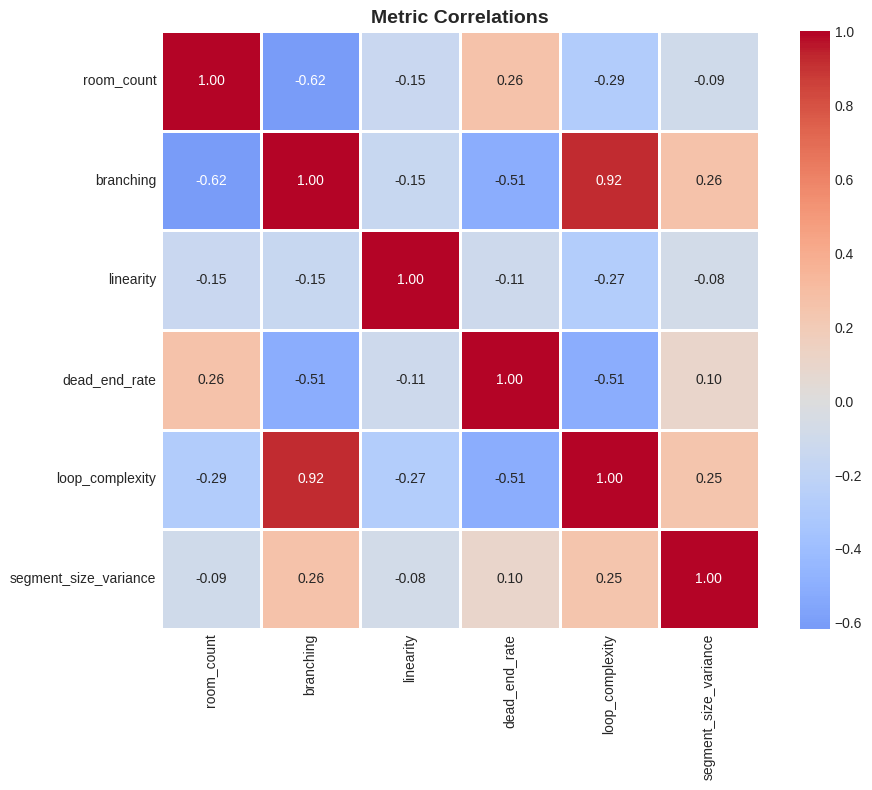

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = df[metric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Metric Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('spelunky_metric_correlations.png', dpi=150, bbox_inches='tight')
print("💾 Saved: spelunky_metric_correlations.png")
plt.show()

💾 Saved: spelunky_metric_pairplot.png


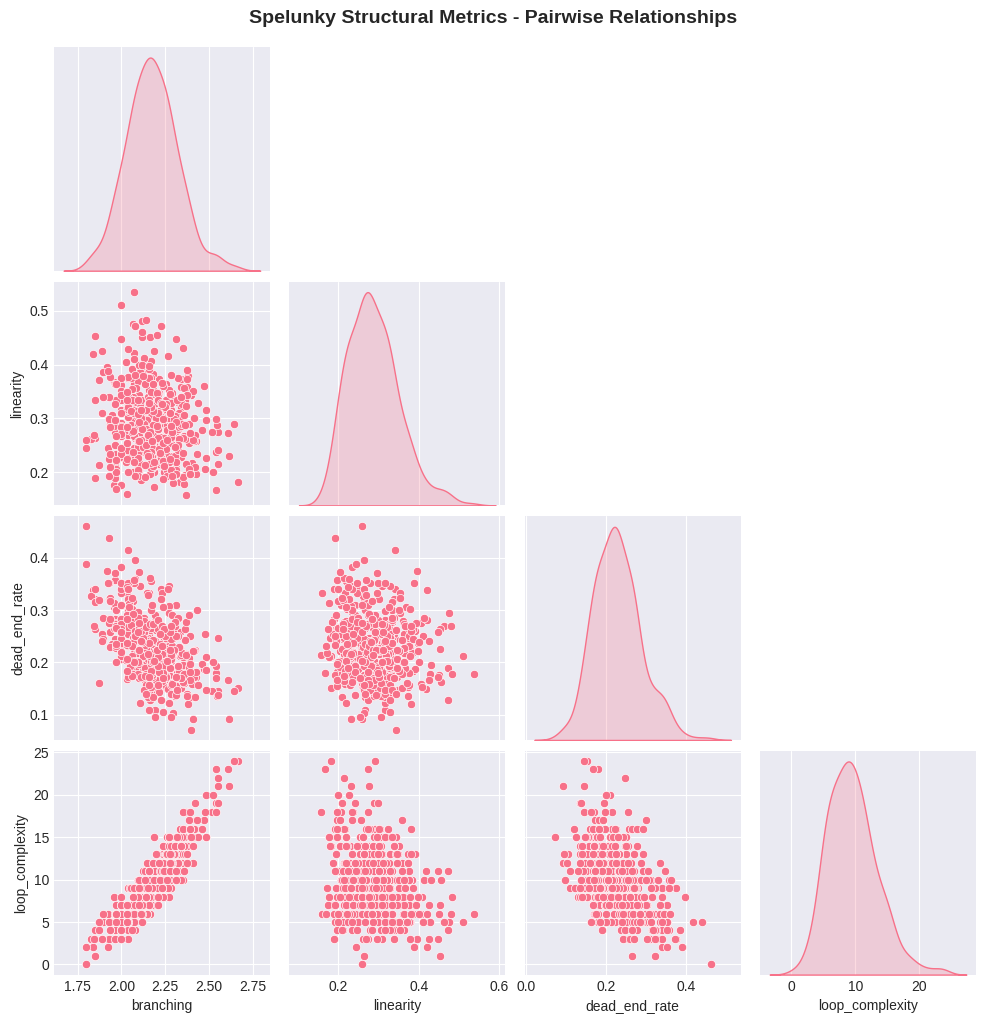

In [14]:
# Pairplot for key metrics
key_metrics = ['branching', 'linearity', 'dead_end_rate', 'loop_complexity']
pairplot = sns.pairplot(df[key_metrics], diag_kind='kde', corner=True)
pairplot.fig.suptitle('Spelunky Structural Metrics - Pairwise Relationships', 
                      y=1.02, fontsize=14, fontweight='bold')
plt.savefig('spelunky_metric_pairplot.png', dpi=150, bbox_inches='tight')
print("💾 Saved: spelunky_metric_pairplot.png")
plt.show()

💾 Saved: spelunky_metric_boxplots.png


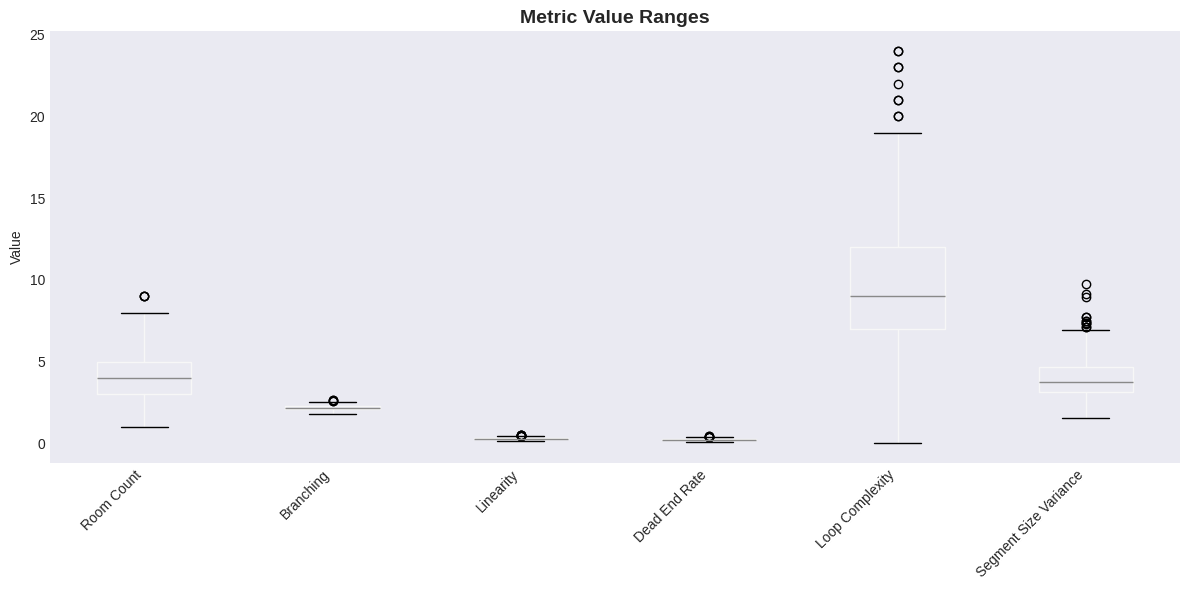

In [15]:
# Box plots for metric spread
fig, ax = plt.subplots(figsize=(12, 6))
df[metric_cols].boxplot(ax=ax, grid=False)
ax.set_title('Metric Value Ranges', fontsize=14, fontweight='bold')
ax.set_ylabel('Value')
ax.set_xticklabels([m.replace('_', ' ').title() for m in metric_cols], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('spelunky_metric_boxplots.png', dpi=150, bbox_inches='tight')
print("💾 Saved: spelunky_metric_boxplots.png")
plt.show()

## 5. Identify Style Clusters (Optional)

In [16]:
# Find extreme examples for different metrics
print("🎯 Extreme Examples:\n")

for metric in ['branching', 'linearity', 'dead_end_rate', 'loop_complexity']:
    print(f"\n{metric.upper().replace('_', ' ')}:")
    
    # Highest
    highest = df.nlargest(3, metric)
    print(f"  Highest:")
    for idx, row in highest.iterrows():
        print(f"    - {idx}: {row[metric]:.3f}")
    
    # Lowest
    lowest = df.nsmallest(3, metric)
    print(f"  Lowest:")
    for idx, row in lowest.iterrows():
        print(f"    - {idx}: {row[metric]:.3f}")

🎯 Extreme Examples:


BRANCHING:
  Highest:
    - level_20251023_074246: 2.667
    - level_20251023_074350: 2.645
    - level_20251023_080615: 2.615
  Lowest:
    - level_20251023_081553: 1.796
    - level_20251023_081455: 1.800
    - level_20251023_074137: 1.826

LINEARITY:
  Highest:
    - level_20251023_075641: 0.536
    - level_20251023_080050: 0.511
    - level_20251023_081023: 0.482
  Lowest:
    - level_20251023_080159: 0.157
    - level_20251023_073528: 0.159
    - level_20251023_075050: 0.167

DEAD END RATE:
  Highest:
    - level_20251023_081455: 0.460
    - level_20251023_080641: 0.439
    - level_20251023_080340: 0.415
  Lowest:
    - level_20251023_080231: 0.071
    - level_20251023_080615: 0.092
    - level_20251023_074603: 0.093

LOOP COMPLEXITY:
  Highest:
    - level_20251023_074246: 24.000
    - level_20251023_074350: 24.000
    - level_20251023_075050: 23.000
  Lowest:
    - level_20251023_081455: 0.000
    - level_20251023_073643: 1.000
    - level_20251023_075220: 

In [18]:
# Export summary for style-aware generation
summary = {
    'dataset_size': len(df),
    'metric_statistics': df[metric_cols].describe().to_dict(),
    'metric_correlations': correlation.to_dict(),
    'sample_targets': {
        'high_branching': df.nlargest(1, 'branching').iloc[0][metric_cols].to_dict(),
        'high_linearity': df.nlargest(1, 'linearity').iloc[0][metric_cols].to_dict(),
        'balanced': df[metric_cols].median().to_dict()  # Changed this line
    }
}

with open('spelunky_metrics_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("💾 Summary saved to spelunky_metrics_summary.json")

💾 Summary saved to spelunky_metrics_summary.json


## ✅ Pipeline Complete!

**Output files:**
- `spelunky_metrics.json` - Raw metrics for all levels
- `spelunky_metrics_summary.json` - Statistical summary and sample targets
- `spelunky_metric_distributions.png` - Histograms
- `spelunky_metric_correlations.png` - Correlation heatmap
- `spelunky_metric_pairplot.png` - Pairwise relationships
- `spelunky_metric_boxplots.png` - Value ranges

**Next steps:**
1. Use `spelunky_metrics_summary.json` to define target styles
2. Implement style-aware generator that matches target metrics
3. Compare generated levels with baselines (random, constructive)